In [1]:
!pip install pandas
!pip install scipy
!pip install pulp
!pip install re
!pip install fuzzywuzzy

ERROR: Could not find a version that satisfies the requirement re (from versions: none)
ERROR: No matching distribution found for re


In [2]:
import pandas as pd
from scipy.optimize import linprog
from pulp import LpMaximize, LpMinimize, LpProblem, LpStatus, lpSum, LpVariable
import re
from fuzzywuzzy import process

C:\Users\anish\AppData\Local\Programs\Python\Python310\lib\site-packages\fuzzywuzzy\fuzz.py:11: UserWarning: Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning
  warnings.warn('Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning')


In [3]:
routes = pd.read_csv('outputs/selected_routes.csv')
attractions = pd.read_csv('mr-qap/mr-qap-results.csv').round(2)
refugee_data = pd.read_csv('refugee_data/refugee_conflict_5.20.22.csv')

In [4]:
total_refugees = refugee_data[refugee_data.conflict=='Ukraine'].refugees.sum()
print(total_refugees)

6824517


## Population lookups with Geonames

First we load in Geonames data for Ukraine. We round the lat/lon to the whole number which gives ~100km resolution. This seems reasonable; people would be affected by a conflict within a 100km radius.

We then get population figures at the admin 2 level, since those are the levels which sum to 44M (the correct population figure for Ukraine)

In [5]:
features = ['PPL', 'PPLA', 'PPLA2',' PPLA3', 'PPLA4', 'PPLA5','PPLC','PPLCH','PPLF','PPLG','PPLH','PPLQ','PPLR','PPLS',
            'PPLW','PPLX','RGN']

In [6]:
CITY_FILE = "inputs/UA.txt"
city_df = pd.read_csv(
    CITY_FILE,
    sep="\t",
    header=0,
    names=[
        "geonameid",
        "name",
        "asciiname",
        "alternatenames",
        "latitude",
        "longitude",
        "feature class",
        "feature code",
        "country code",
        "cc2",
        "admin1 code",
        "admin2 code",
        "admin3 code",
        "admin4 code",
        "population",
        "elevation",
        "dem",
        "timezone",
        "modification date",
    ],
)

city_df = city_df[city_df['feature code'].isin(features)]

# city_df_a1 = city_df.dropna(subset=['admin1 code'])
# city_df = city_df.dropna(subset=['admin2 code'])

subset_cols = ["name", "latitude", "longitude", "country code", "population"]
city_df = city_df[city_df['country code'] == 'UA'].reset_index()
city_df = city_df[subset_cols]
city_df['lat'] = city_df.latitude.round(0)
city_df['lon'] = city_df.longitude.round(0)

population = pd.DataFrame(city_df.groupby(['lat','lon']).population.sum()).reset_index()
print(population.population.sum())

C:\Users\anish\AppData\Local\Temp\ipykernel_17344\4043745648.py:2: DtypeWarning: Columns (11) have mixed types. Specify dtype option on import or set low_memory=False.
  city_df = pd.read_csv(


42503255


In [7]:
routes['lat'] = routes.conflict_lat.round(0)
routes['lon'] = routes.conflict_lon.round(0)

In [8]:
routes.shape

(406, 13)

In [9]:
routes = pd.merge(routes, population, left_on=['lat','lon'], right_on=['lat','lon'])

In [10]:
routes.shape

(406, 14)

In [11]:
del(routes['lat'])
del(routes['lon'])

In [12]:
routes.head()

,conflict,crossing,crossing_country,duration,duration_text,mode,crossing_lat,crossing_lon,conflict_lat,conflict_lon,fatalities,population
0,Oleksandrivka,Yahodyn - Dorohusk,Poland,59002.0,16 hours 23 mins,driving,51.185221,23.807771,46.6,32.1,100.0,694977
1,Oleksandrivka,Platonove - Hoianul Nou,Moldova,38239.0,10 hours 37 mins,driving,47.403518,29.329999,46.6,32.1,100.0,694977
2,Oleksandrivka,Porubne - Siret,Romania,54337.0,15 hours 6 mins,driving,47.988980,26.060076,46.6,32.1,100.0,694977
3,Oleksandrivka,Malyi Bereznyi - Ubl'a,Slovakia,68319.0,18 hours 59 mins,driving,48.885205,22.420625,46.6,32.1,100.0,694977
4,Oleksandrivka,Chop (Tysa) - Zakhon,Hungary,69480.0,19 hours 18 mins,driving,48.418594,22.170066,46.6,32.1,100.0,694977


In [13]:
total_affected_population = routes.drop_duplicates(subset=['conflict']).population.sum()
print(total_affected_population)

38916353


In [14]:
refugee_ratio = total_refugees / total_affected_population
print(round(refugee_ratio,3))

0.175


## Generate Linear Optimization Model

In [15]:
def adjust_duration_transit(row):
    """
    Hardcoded adjustment to transit (divide duration by 4) as an equivalency measure to driving.
    In that case, a 8 hour train ride is equivalent to a 2 hour car ride.
    """
    if row['mode'] == 'transit':
        row.duration = row.duration / 4
    return row

routes = routes.apply(lambda row: adjust_duration_transit(row), axis=1)

In [16]:
attractions = dict(zip(attractions.country, attractions.predicted_shares))

In [17]:
attractions

{'Hungary': 0.11,
 'Belarus': 0.03,
 'Moldova': 0.12,
 'Poland': 0.18,
 'Romania': 0.17,
 'Russian Federation': 0.19,
 'Slovakia': 0.2}

`min{sum(duration)}`

each `(conflict, crossing)` pair is a variable for total fatalities routed

the sum of `sum{(conflict, crossing)}` for each conflict `i` must equal total fatalities for that conflict.

`(conflict, crossing)` is continuous but can equal 0

the sum of each `country` fatalities divided by total fatalities must equal that country's `predicted_shares`

In [18]:
def get_population(conflict):
    population = routes[routes.conflict==conflict].iloc[0].population
    return population

In [19]:
reg = re.compile(r'[\W]')

In [20]:
def strip_text(text):
    return re.sub(reg, '', text).lower()

In [21]:
conflicts = routes.conflict.unique()
crossings = routes.crossing.unique()
countries = routes.crossing_country.unique()

In [22]:
model = LpProblem(name="refugee-routing", sense=LpMinimize)

In [23]:
variables = {}
variables_lookup = {}

for conf in conflicts:
    variables[conf] = []
    
for kk, vv in routes.iterrows():
    conf = strip_text(vv.conflict)
    cross = strip_text(vv.crossing)
    country = strip_text(vv.crossing_country)
    mode = vv['mode']
    v = f"{conf}__{cross}__{country}__{mode}"
    x = LpVariable(name=v, lowBound=0, cat='Continuous')
    variables[vv.conflict].append(x)
    
    variables_lookup[v] = dict(conflict=vv.conflict,
                               crossing=vv.crossing,
                               country=vv.crossing_country,
                               mode=mode,
                               duration=vv.duration)

In [24]:
vars_by_country = {}
for country in countries:
    vars_by_country[country] = []

for kk, vv in variables.items():
    for i in vv:
        country = variables_lookup[i.name]['country']
        vars_by_country[country].append(i)

In [25]:
for conf in conflicts:
    pop = get_population(conf)
    model += (lpSum(variables[conf]) == round(refugee_ratio * pop,0), 
              f"{conf}_refugee_constraint") 

In [26]:
for c in countries[:6]:
    country_vars = vars_by_country[c]
    attraction = round(attractions[c],2)
    
    model += (lpSum(country_vars)/total_refugees == attraction,
              f"{c}_attraction")

In [27]:
obj_func_array = []
for kk, vv in variables.items():
    for i in vv:
        refugees = i
        duration = variables_lookup[i.name]['duration']
        obj_func_array.append(refugees*duration)

In [28]:
model += lpSum(obj_func_array)

In [29]:
status = model.solve()

In [30]:
print(f"status: {model.status}, {LpStatus[model.status]}")
print(f"objective: {model.objective.value()}")


for var in model.variables():
    print(f"{var.name}: {var.value()}")

for name, constraint in model.constraints.items():
    print(f"{name}: {constraint.value()}")

status: 1, Optimal
objective: 217225853235.82248
baryshivka__choptysazakhon__hungary__driving: 0.0
baryshivka__malyibereznyiubla__slovakia__driving: 0.0
baryshivka__platonovehoianulnou__moldova__driving: 0.0
baryshivka__porubnesiret__romania__driving: 0.0
baryshivka__senkivkanoviyurkovychi__russianfederation__driving: 0.0
baryshivka__slavutychkomaryn__belarus__driving: 0.0
baryshivka__yahodyndorohusk__poland__driving: 536622.0
bilohorivka__choptysazakhon__hungary__driving: 0.0
bilohorivka__krasnatalivkavoloshino__russianfederation__driving: 0.0
bilohorivka__malyibereznyiubla__slovakia__driving: 0.0
bilohorivka__platonovehoianulnou__moldova__driving: 0.0
bilohorivka__porubnesiret__romania__driving: 162643.0
bilohorivka__vilchaoleksandrivka__belarus__driving: 0.0
bilohorivka__yahodyndorohusk__poland__driving: 0.0
borodianka__choptysazakhon__hungary__driving: 0.0
borodianka__malyibereznyiubla__slovakia__driving: 0.0
borodianka__mohylivpodilskyiotach__moldova__driving: 0.0
borodianka__poru

In [31]:
refugee_counts = {}
for c in countries:
    refugee_counts[c] = 0

In [32]:
for var in model.variables():
    for c in countries:
        if c.split(' ')[0].lower() in var.name.lower():
            refugee_counts[c] += var.value()

In [33]:
for kk, vv in refugee_counts.items():
    ratio = round(vv/total_refugees,2)
    print(f"{kk}: {ratio}")

Poland: 0.18
Moldova: 0.12
Romania: 0.17
Slovakia: 0.2
Hungary: 0.11
Belarus: 0.03
Russian Federation: 0.19


In [34]:
attractions

{'Hungary': 0.11,
 'Belarus': 0.03,
 'Moldova': 0.12,
 'Poland': 0.18,
 'Romania': 0.17,
 'Russian Federation': 0.19,
 'Slovakia': 0.2}

In [35]:
for kk, vv in refugee_counts.items():
    refs = round(vv)
    print(f"{kk}: {refs}")

Poland: 1228413
Moldova: 818942
Romania: 1160168
Slovakia: 1364903
Hungary: 750697
Belarus: 204736
Russian Federation: 1296656


In [36]:
results = []
for var in model.variables():
    results.append((var, var.value()))
results = pd.DataFrame(results, columns=['variable','value'])    

In [37]:
results['conflict'] = results.variable.apply(lambda x: variables_lookup[x.name]['conflict'])
results['crossing'] = results.variable.apply(lambda x: variables_lookup[x.name]['crossing'])
results['country'] = results.variable.apply(lambda x: variables_lookup[x.name]['country'])
results['mode'] = results.variable.apply(lambda x: variables_lookup[x.name]['mode'])

In [38]:
results.to_csv('outputs/linear_prog_results.csv', index=False)

In [39]:
!pip install matplotlib

In [40]:
print(model)

refugee-routing:
MINIMIZE
43006.0*baryshivka__choptysazakhon__hungary__driving + 41268.0*baryshivka__malyibereznyiubla__slovakia__driving + 21706.0*baryshivka__platonovehoianulnou__moldova__driving + 32566.0*baryshivka__porubnesiret__romania__driving + 16752.0*baryshivka__senkivkanoviyurkovychi__russianfederation__driving + 11983.0*baryshivka__slavutychkomaryn__belarus__driving + 27007.0*baryshivka__yahodyndorohusk__poland__driving + 72941.0*bilohorivka__choptysazakhon__hungary__driving + 10102.0*bilohorivka__krasnatalivkavoloshino__russianfederation__driving + 71203.0*bilohorivka__malyibereznyiubla__slovakia__driving + 49287.0*bilohorivka__platonovehoianulnou__moldova__driving + 62501.0*bilohorivka__porubnesiret__romania__driving + 42486.0*bilohorivka__vilchaoleksandrivka__belarus__driving + 57105.0*bilohorivka__yahodyndorohusk__poland__driving + 38625.0*borodianka__choptysazakhon__hungary__driving + 36886.0*borodianka__malyibereznyiubla__slovakia__driving + 17832.0*borodianka__mohyli

In [41]:
import pandas as pd

In [42]:
o = [{'name':name, 'shadow price':c.pi, 'slack':c.slack}
    for name,c in model.constraints.items()]
print(pd.DataFrame(o))

                                                 name  shadow price  slack
0                    Oleksandrivka_refugee_constraint -5.390000e+02   -0.0
1                        Kyselivka_refugee_constraint -1.681000e+03   -0.0
2                         Mykolaiv_refugee_constraint -3.195000e+04   -0.0
3                          Oleshky_refugee_constraint -3.011000e+03   -0.0
4                          Kherson_refugee_constraint -3.112950e+04   -0.0
5             Velyka_Oleksandrivka_refugee_constraint -9.021000e+03   -0.0
6                          Kobleve_refugee_constraint -3.552000e+04   -0.0
7                        Melitopol_refugee_constraint  1.556000e+03   -0.0
8                         Mariupol_refugee_constraint  3.640000e+03   -0.0
9                           Polohy_refugee_constraint  2.520000e+02   -0.0
10                      Volnovakha_refugee_constraint  6.437000e+03   -0.0
11                         Donetsk_refugee_constraint  6.568000e+03   -0.0
12                 Novoba

In [43]:
import matplotlib.pyplot as plt

In [44]:
df = pd.DataFrame(o)

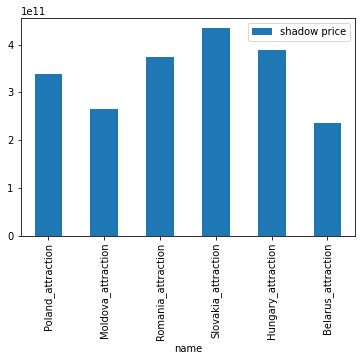

In [63]:
df.loc[df['shadow price'] > 10000000000].plot(x='name', y='shadow price', kind = 'bar')
plt.show()

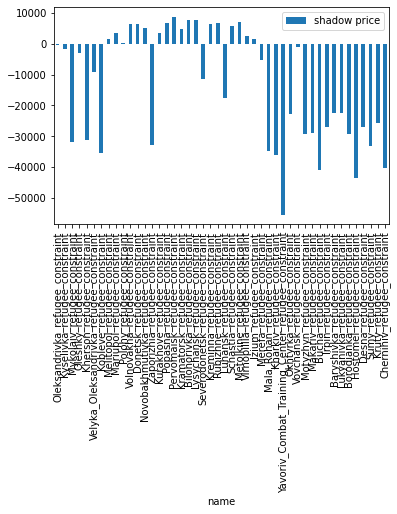

In [64]:
df.loc[df['shadow price'] < 10000000000].plot(x='name', y='shadow price', kind = 'bar')
plt.show()